In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lmfit as lm

In [4]:
egfp = pd.read_excel("data-siRNA/2017_06_02_seq6_Huh7_controll_#molecules.xlsx",sheet="#GFP_corrected").dropna()

In [27]:
egfp_data = egfp.values.T

In [28]:
egfp_data.shape

(443, 150)

In [29]:
time = egfp_data[0].astype(np.double)
egfp_data = egfp_data[1:].astype(np.double)
time

array([ -0.8,  -0.6,  -0.4,  -0.2,   0. ,   0.2,   0.4,   0.6,   0.8,
         1. ,   1.2,   1.4,   1.6,   1.8,   2. ,   2.2,   2.4,   2.6,
         2.8,   3. ,   3.2,   3.4,   3.6,   3.8,   4. ,   4.2,   4.4,
         4.6,   4.8,   5. ,   5.2,   5.4,   5.6,   5.8,   6. ,   6.2,
         6.4,   6.6,   6.8,   7. ,   7.2,   7.4,   7.6,   7.8,   8. ,
         8.2,   8.4,   8.6,   8.8,   9. ,   9.2,   9.4,   9.6,   9.8,
        10. ,  10.2,  10.4,  10.6,  10.8,  11. ,  11.2,  11.4,  11.6,
        11.8,  12. ,  12.2,  12.4,  12.6,  12.8,  13. ,  13.2,  13.4,
        13.6,  13.8,  14. ,  14.2,  14.4,  14.6,  14.8,  15. ,  15.2,
        15.4,  15.6,  15.8,  16. ,  16.2,  16.4,  16.6,  16.8,  17. ,
        17.2,  17.4,  17.6,  17.8,  18. ,  18.2,  18.4,  18.6,  18.8,
        19. ,  19.2,  19.4,  19.6,  19.8,  20. ,  20.2,  20.4,  20.6,
        20.8,  21. ,  21.2,  21.4,  21.6,  21.8,  22. ,  22.2,  22.4,
        22.6,  22.8,  23. ,  23.2,  23.4,  23.6,  23.8,  24. ,  24.2,
        24.4,  24.6,

Text(0,0.5,'# if GFP molecules')

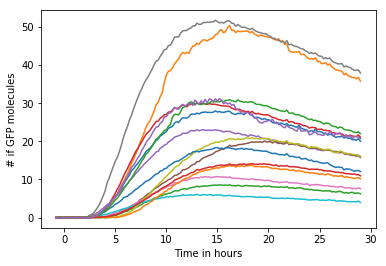

In [30]:
for data in egfp_data[:15]:
    plt.plot(time,data)
plt.xlabel("Time in hours")
plt.ylabel("# if GFP molecules")

In [18]:
def egfp_expression(t,ktm,delta,beta,t0):
    result = ktm/(delta-beta)*(1-np.exp(-(delta-beta)*(t-t0)))*np.exp(-beta*(t-t0))
    result[t<t0]=0
    return result

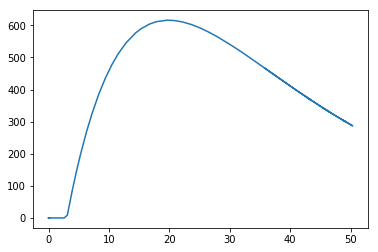

In [19]:
plt.plot(time,egfp_expression(time,100,0.05,0.07,3))

In [20]:
egfp_mod = lm.Model(egfp_expression)

In [37]:
data = egfp_data[10]

[[Model]]
    Model(egfp_expression)
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 226
    # data points      = 150
    # variables        = 4
    chi-square         = 66.3569375
    reduced chi-square = 0.45449957
    Akaike info crit   = -114.338047
    Bayesian info crit = -102.295506
[[Variables]]
    ktm:    4.02337823 (init = 3)
    delta:  0.08409353 (init = 0.05)
    beta:   0.08408695 (init = 0.07)
    t0:     4.50559412 (init = 6)

[[Model]]
    Model(egfp_expression)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 150
    # variables        = 4
    chi-square         = 66.3569370
    reduced chi-square = 0.45449957
    Akaike info crit   = -114.338048
    Bayesian info crit = -102.295507
[[Variables]]
    ktm:    4.02334277 +/- 0.07397217 (1.84%) (init = 3)
    delta:  0.08409113 +/- 16.8601401 (20049.84%) (init = 0.05)
    beta:   0.08408833 +/- 16.8616536 (20052.31%) (init = 0.07)
 

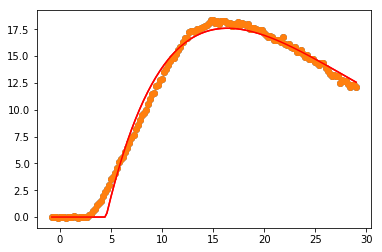

In [38]:
pars = egfp_mod.make_params()
pars['ktm'].set(value=3,vary=True,min=0)
pars['delta'].set(value=0.05,vary=True,min=0)
pars['beta'].set(value=0.07,vary=True,min=0)
pars['t0'].set(value=6,vary=True,min=0)

result0 = egfp_mod.fit(data,pars,t=time,method='nelder')

print(result0.fit_report())

plt.plot(time,data,"o")
plt.plot(time, result0.best_fit, 'r-')

result = egfp_mod.fit(data,pars,t=time,method='leastsq')

print(result.fit_report())

plt.plot(time,data,"o")
plt.plot(time, result.best_fit, 'r-')


In [35]:
def chisqTwoStage(t,data,delta,beta,t0,ktm):
    time = t-t0
    middle = 1 - np.exp(-((delta-beta)*time[:,np.newaxis,np.newaxis]))
    last = np.exp(-beta*time[:,np.newaxis,np.newaxis])
    first = ktm/(delta-beta)
    y = first*middle*last
    res = (data - y.T).T
    return np.sum(res**2,axis=0)

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply


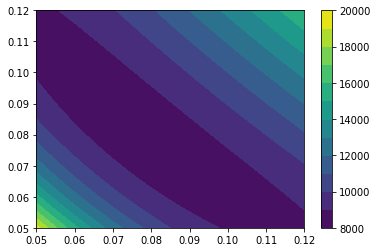

In [41]:
# let us plot the two-dimensional chi^2 distribution
beta = np.linspace(0.05,0.12,401)
delta = np.linspace(0.05,.12,401)

B,D = np.meshgrid(beta,delta)
#print(M.shape)
Z = chisqTwoStage(time,data,D,B,result.values['t0'],result.values['ktm'])
plt.contourf(B, D, Z,10)
plt.colorbar()